Let's go through what's necessary for the calculation of the thermal conductivity for any given time step during the TRT at specific locations:

In [1]:
%matplotlib inline

1. Read in the existing dataset: $T_s,T_r,Watts,t$, from the trt dataset
2. Find the gradient of temperature (whichever should be fine) to the natural log of hours, so your $m = \frac{dT}{d ln(t)}$
3. Using the gradient of the temperature, it is already possible to estimate the thermal conductivity, using $k_s = \frac{Q}{4\pi m}$
4. The thermal diffusivity can then be evaluated at $\alpha_s = \frac{k_s}{c_p}$,where the heat capacity is a known value: 37.5 in IP units
5. The borehole resistence may therefore be calculated as 
$R_b = \frac{1}{4\pi k_s}$ $(\frac{T_m - T_{rs}}{m}-ln\frac{4\alpha_s t}{r_b^2})$

The question then becomes... how do we evaluate the thermal conductivity at different depths of the well? It actually is pretty simple - we just need to use a few of the further simplifications that we've already seen.

If I remember correctly, the first thing we want to do is to slice the existing data to a dataframe that has all the information we want/need:
1. Find the time stamps we're looking for
2. Combine and convert the existing files into ones that has the following columns: annulus, grout, **CONSISTENT** time, and corresponding heat injection rates
_Note this will be problematic because we have four-minute-intervals while the other have five-minute ones... but nonetheless this is a key step to complete, and we can call quit today once this is achieved._
3. Calculate $R_{b,g}$
4. Calculate the corresponding $k_{s,i}$ using the equation on notebook

### Measurement Time
Start - Sep, 10th, 17:40:50 

End - Sep, 12th, 18:10:00

In [2]:
#Now let's try to process these folders/file data
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import os
from glob import glob

In [206]:
ts = glob('pt0920/channel 1/2019/sep/*00001.ddf')

In [207]:
ts.sort()

In [208]:
ts[-1]>ts[0]

True

In [209]:
s1 = 'pt0920/channel 1/2019/sep/'
s2 = 'pt0920/channel 2/2019/sep/'
s3 = 'pt0920/channel 3/2019/sep/'
s4 = 'pt0920/channel 4/2019/sep/'
s0 = '*00001.ddf'
s = [s0,s1,s2,s3,s4]

In [210]:
fl = []
for i in s[1:]:
    fi = glob(i+s0)
    fi.sort()
    ref1 = i + i[7:16] + ' 20190910 174000' + s0[1:]
    ref2 = i + i[7:16] + ' 20190912 181000' + s0[1:]
    fin = fi[bisect.bisect_right(fi,ref1):]
    fnn = fin[:bisect.bisect_left(fin,ref2)]
    fl.append(fnn)
    print i+s0

pt0920/channel 1/2019/sep/*00001.ddf
pt0920/channel 2/2019/sep/*00001.ddf
pt0920/channel 3/2019/sep/*00001.ddf
pt0920/channel 4/2019/sep/*00001.ddf


So, good news is we now have fl as the names of the files that we want to harvest, so we do have things in order. Now that's assemble the csvs together. 

Note that Channel 1, 3 are inner duplicates, 2,4 are outer duplicates.

In [211]:
for i in range(4):
    print len(fl[i])
    
#We're working only C3 and C4 for now since they happen to ...! have consistent lengths.

715
696
686
691


In [212]:
with open('ins','rb') as f:
    inss = pickle.load(f)
insf = ['%.3f' % elem for elem in inss]

In [289]:
f23 = fl[2]
all3 = pd.DataFrame()
for i in range(len(f23)):
    fram = pd.read_csv(f23[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    DF = fram[fram['depth']>0]
    DF = DF.set_index('depth')
    DF = DF.transpose()
    s = DF.iloc[0].astype(float)
    s.name = str(f23[i])[-25:-25+8]+str(f23[i])[-25+9:-25+15]
#     print s
    all3 = all3.append(s)

In [214]:
all3.tail()

0.556    1.571    2.586    3.600    4.615    5.629    6.644    \
20190912180404   34.748   31.462   27.454   25.510   24.123   20.813   11.274   
20190912180504   34.766   31.586   27.769   26.049   24.395   20.567   11.636   
20190912180604   34.487   31.400   27.705   25.788   24.499   20.589   11.385   
20190912180704   34.424   31.146   27.242   25.832   24.305   20.555   11.531   
20190912180904   34.717   31.315   27.672   25.646   24.288   20.398   11.621   

                7.659    8.673    9.688    ...  413.496  414.511  415.526  \
20190912180404    4.070    3.218    3.319  ...   29.337   29.455   29.525   
20190912180504    4.074    3.401    2.803  ...   29.821   29.384   29.788   
20190912180604    4.036    3.314    3.108  ...   29.440   29.550   29.281   
20190912180704    4.111    3.034    2.934  ...   29.483   29.492   29.127   
20190912180904    4.329    3.369    3.153  ...   29.658   29.470   29.573   

                416.540  417.555  418.569  419.584  420.599  421.613  422.628  
20190912180404   29.411   28.992   29.172   29.089   29.429  159.200  138.015  
20190912180504   29.713   29.608   29.076   29.365   29.104  159.626  138.420  
20190912180604   29.597   29.062   28.948   29.103   29.218  159.166  137.987  
20190912180704   29.303   29.449   29.002   28.864   28.796  158.967  137.810  
20190912180904   29.562   29.379   29.381   29.028   29.216  159.391  138.153  

[5 rows x 417 columns]

In [290]:
f24 = fl[3]
all4 = pd.DataFrame()
for i in range(len(f24)):
    fram = pd.read_csv(f24[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    DF = fram[fram['depth']>0]
    DF = DF.set_index('depth')
    DF = DF.transpose()
    s = DF.iloc[0].astype(float)
    s.name = str(f24[i])[-25:-25+8]+str(f24[i])[-25+9:-25+15]
#     print s
    all4 = all4.append(s)

In [216]:
all3.describe()

0.556       1.571       2.586       3.600       4.615       5.629    \
count  686.000000  686.000000  686.000000  686.000000  686.000000  686.000000   
mean    34.178595   31.314465   27.825373   26.130101   24.631875   20.824929   
std      5.232315    5.259066    5.102314    4.937556    4.642868    3.692393   
min     26.679000   23.868000   20.558000   19.064000   18.042000   15.589000   
25%     29.683000   26.714500   23.193000   21.574750   20.455500   17.622750   
50%     33.662000   30.857000   27.599500   25.912000   24.488500   20.750000   
75%     38.365250   35.400500   31.402750   29.519750   27.698000   22.954000   
max     55.454000   52.672000   49.517000   47.790000   45.919000   41.231000   

          6.644       7.659       8.673       9.688    ...     413.496  \
count  686.000000  686.000000  686.000000  686.000000  ...  686.000000   
mean    10.591738    2.478055    1.298657    1.089520  ...   25.939061   
std      2.359654    1.795329    1.782961    1.763852  ...    3.103324   
min      7.399000    0.676000   -0.290000   -0.449000  ...   18.426000   
25%      8.586000    1.117500   -0.047500   -0.225000  ...   23.638500   
50%     10.898500    2.756500    1.400000    1.141000  ...   26.453000   
75%     11.686000    3.295250    2.218500    1.959500  ...   28.109000   
max     29.868000   21.246000   20.091000   19.909000  ...   48.443000   

          414.511     415.526     416.540     417.555     418.569     419.584  \
count  686.000000  686.000000  686.000000  686.000000  686.000000  686.000000   
mean    26.026118   26.030741   26.005806   25.946321   25.680781   25.619424   
std      3.111285    3.111018    3.108597    3.102379    3.099326    3.100759   
min     18.397000   18.213000   18.340000   18.194000   17.978000   18.067000   
25%     23.769750   23.751750   23.706500   23.628750   23.368000   23.328000   
50%     26.532000   26.558500   26.496000   26.428500   26.235000   26.129500   
75%     28.205500   28.199250   28.168750   28.117250   27.847000   27.798250   
max     48.457000   48.570000   48.565000   48.470000   48.109000   48.021000   

          420.599     421.613     422.628  
count  686.000000  686.000000  686.000000  
mean    25.707633  124.672972  107.514729  
std      3.103864   28.160610   24.739205  
min     18.192000   82.851000   70.174000  
25%     23.396250  101.249500   87.175750  
50%     26.238000  110.792000   95.556500  
75%     27.878750  156.770000  135.513250  
max     48.239000  206.913000  181.287000  

[8 rows x 417 columns]

In [217]:
all4.describe()

0.556       1.571       2.586       3.600       4.615       5.629    \
count  691.000000  691.000000  691.000000  691.000000  691.000000  691.000000   
mean    34.117750   29.991329   25.992732   24.904197   24.277463   18.326890   
std      5.228377    5.178482    4.948807    4.771881    4.441682    3.346299   
min     26.618000   22.554000   18.820000   17.920000   17.773000   13.607000   
25%     29.636000   25.417000   21.548000   20.509000   20.252500   15.500500   
50%     33.609000   29.664000   25.854000   24.781000   24.129000   18.370000   
75%     38.171000   33.929000   29.561500   28.272500   27.244000   20.345000   
max     55.493000   51.268000   47.035000   45.844000   44.901000   37.968000   

          6.644       7.659       8.673       9.688    ...     413.496  \
count  691.000000  691.000000  691.000000  691.000000  ...  691.000000   
mean     7.363437    1.655615    1.181797    1.125069  ...   27.443333   
std      2.042650    1.708030    1.705572    1.706280  ...    3.118467   
min      4.764000    0.056000   -0.353000   -0.421000  ...   19.613000   
25%      5.737500    0.299500   -0.176000   -0.222500  ...   25.150000   
50%      7.843000    1.924000    1.282000    1.189000  ...   28.022000   
75%      8.452500    2.514500    2.047000    2.006000  ...   29.625000   
max     26.122000   20.389000   20.007000   19.861000  ...   49.986000   

          414.511     415.526     416.540     417.555     418.569     419.584  \
count  691.000000  691.000000  691.000000  691.000000  691.000000  691.000000   
mean    27.441618   27.465220   27.462609   27.463016   27.461728   27.470784   
std      3.122902    3.118113    3.116252    3.122480    3.121426    3.117546   
min     19.578000   19.623000   19.644000   19.681000   19.653000   19.651000   
25%     25.192500   25.180000   25.166500   25.145500   25.182000   25.193500   
50%     27.993000   28.021000   28.019000   27.997000   27.992000   28.002000   
75%     29.613000   29.629000   29.656000   29.638000   29.658000   29.668500   
max     50.054000   49.991000   50.030000   49.975000   50.049000   49.965000   

          420.599     421.613     422.628  
count  691.000000  691.000000  691.000000  
mean    27.495887  108.324543  107.038588  
std      3.122312   25.990536   24.396063  
min     19.613000   68.948000   69.651000  
25%     25.201000   87.960000   88.121000  
50%     27.993000   95.310000   94.827000  
75%     29.682500  137.908000  134.519500  
max     50.104000  183.834000  180.355000  

[8 rows x 417 columns]

In [218]:
all3.index.values[0]

'20190910174210'

In [291]:
all3['DT'] = pd.to_datetime(all3.index.values)
all4['DT'] = pd.to_datetime(all4.index.values)

In [292]:
all3 = all3.set_index('DT')
all4 = all4.set_index('DT')

In [293]:
all3.index[0]

Timestamp('2019-09-10 17:42:10')

In [294]:
#This was done manually to calculate the differences in hours
begin = pd.to_datetime('20190910174000')
end = pd.to_datetime('20190912181000')

In [295]:
import numpy as np
all3['hrs'] = all3.index - begin
all3['hrs'] = all3['hrs']/np.timedelta64(1,'h')
all4['hrs'] = all4.index - begin
all4['hrs'] = all4['hrs']/np.timedelta64(1,'h')

In [296]:
all4.tail()

0.556   1.571   2.586     3.6   4.615   5.629  6.644  \
DT                                                                           
2019-09-12 18:04:19  34.769  30.315  25.950  24.960  24.057  18.444  8.532   
2019-09-12 18:05:19  34.646  30.216  25.978  24.650  23.914  18.381  8.429   
2019-09-12 18:06:19  34.544  30.058  25.713  24.727  23.976  18.440  8.304   
2019-09-12 18:07:19  34.492  30.137  25.926  24.734  23.837  18.364  8.536   
2019-09-12 18:09:19  34.457  30.134  25.965  24.790  24.051  18.544  8.284   

                     7.659  8.673  9.688  ...  414.511  415.526  416.54  \
DT                                        ...                             
2019-09-12 18:04:19  3.537  3.083  3.032  ...   31.242   31.194  31.125   
2019-09-12 18:05:19  3.309  2.940  2.949  ...   31.211   31.245  31.090   
2019-09-12 18:06:19  3.297  2.918  2.998  ...   30.940   31.032  30.971   
2019-09-12 18:07:19  3.400  2.932  3.055  ...   30.895   30.725  31.023   
2019-09-12 18:09:19  3.523  2.963  2.840  ...   31.184   30.894  30.759   

                     417.555  418.569  419.584  420.599  421.613  422.628  \
DT                                                                          
2019-09-12 18:04:19   31.428   31.264   31.264   31.353  142.094  138.474   
2019-09-12 18:05:19   31.130   30.938   31.166   31.126  141.749  138.075   
2019-09-12 18:06:19   30.958   30.732   30.894   31.006  141.507  137.820   
2019-09-12 18:07:19   31.054   30.975   30.761   30.781  141.463  137.796   
2019-09-12 18:09:19   30.794   31.157   31.062   30.934  142.017  138.369   

                           hrs  
DT                              
2019-09-12 18:04:19  48.405278  
2019-09-12 18:05:19  48.421944  
2019-09-12 18:06:19  48.438611  
2019-09-12 18:07:19  48.455278  
2019-09-12 18:09:19  48.488611  

[5 rows x 418 columns]

How about we try to just estimate the heat injection rate using the iterative approach here so that we get the heat injection rate at any given point? Should be possible.

In [297]:
xls = pd.read_excel('gtri_raw.xlsx',index_col=0,skiprows=3)
xls = xls.rename(columns={xls.columns[-1]:'HeatIn'})
gtri = xls[['Supply1','Return1','HeatIn','(hr)']].copy()
yinterp = np.interp(gtri['(hr)'],gtri['(hr)'],gtri['HeatIn'])

In [298]:
np.interp(10,gtri['(hr)'],gtri['HeatIn'])

78.13022400461705

In [299]:
#Remember Hin here is already Q over L!!!
all3['Hin'] = np.interp(all3['hrs'],gtri['(hr)'],gtri['HeatIn'])
all4['Hin'] = np.interp(all4['hrs'],gtri['(hr)'],gtri['HeatIn'])

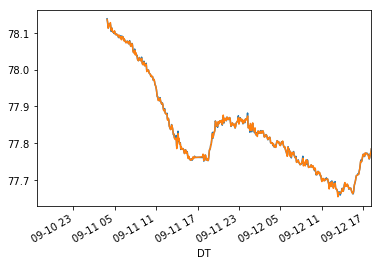

In [300]:
all3.Hin.plot()
all4.Hin.plot()

In [301]:
#Try to remove outlier
all3 = all3[all3[all3.columns[4]] <40]

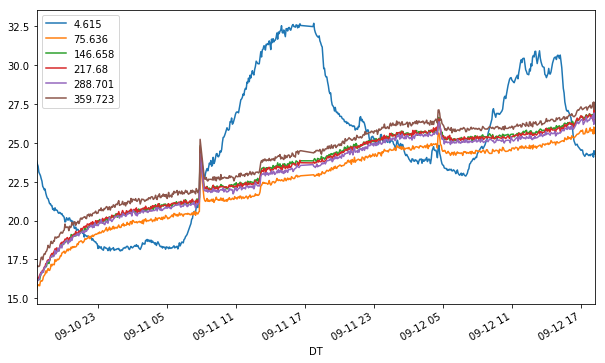

In [302]:
all3[all3.columns[4::70]].plot(figsize=(10,6))

In [341]:
import matplotlib.pyplot as plt

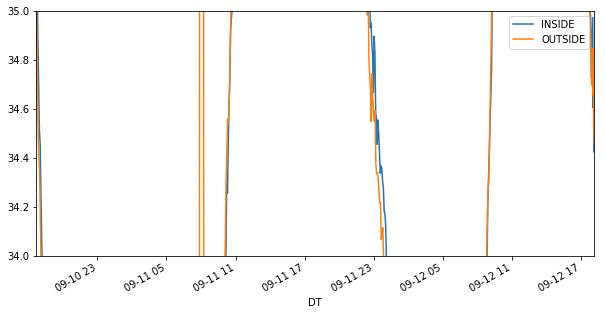

In [352]:
all3[all3.columns[0]].plot(figsize=(10,5),label='INSIDE')
all4[all4.columns[0]].plot(label='OUTSIDE')
plt.ylim(34,35)
plt.legend()

In [314]:
all3.to_csv('C3proc.csv')
all4.to_csv('C4proc.csv')

In [11]:
all3 = pd.read_csv('C3proc.csv',index_col=0)
all4 = pd.read_csv('C4proc.csv',index_col=0)

In [12]:
all3.head(3)

0.556   1.571  2.5860000000000003     3.6   4.615  \
DT                                                                        
2019-09-10 17:42:10  35.028  31.922              27.816  25.583  23.846   
2019-09-10 17:46:11  35.127  31.705              27.450  25.423  23.639   
2019-09-10 17:50:11  34.895  31.502              27.240  25.110  23.501   

                      5.629  6.644  7.659  8.673  9.687999999999999  ...  \
DT                                                                   ...   
2019-09-10 17:42:10  20.057  9.562  1.082 -0.043             -0.307  ...   
2019-09-10 17:46:11  19.904  9.626  1.196 -0.108             -0.308  ...   
2019-09-10 17:50:11  19.754  9.465  1.134 -0.171             -0.273  ...   

                     415.526  416.54  417.555  418.569  419.584  420.599  \
DT                                                                         
2019-09-10 17:42:10   18.213  18.340   18.194   17.978   18.067   18.243   
2019-09-10 17:46:11   18.616  18.664   18.624   18.343   18.234   18.192   
2019-09-10 17:50:11   18.684  18.681   18.634   18.292   18.328   18.456   

                     421.61300000000006  422.62800000000004       hrs  Hin  
DT                                                                          
2019-09-10 17:42:10             150.779             130.645  0.036111  NaN  
2019-09-10 17:46:11             151.299             131.039  0.103056  NaN  
2019-09-10 17:50:11             151.537             131.232  0.169722  NaN  

[3 rows x 419 columns]

In [13]:
AL = all3[all3['hrs']>14]

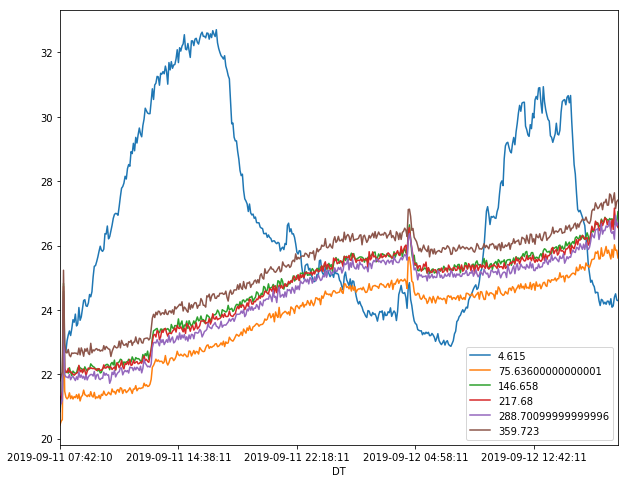

In [14]:
AL[AL.columns[4::70]].plot(figsize=(10,8))

In [15]:
all3.columns[5::60]

Index([u'5.629', u'66.505', u'127.381', u'188.25599999999997', u'249.132',
       u'310.008', u'370.88300000000004'],
      dtype='object')

In [16]:
all3.hrs.head(5)

DT
2019-09-10 17:42:10    0.036111
2019-09-10 17:46:11    0.103056
2019-09-10 17:50:11    0.169722
2019-09-10 17:54:11    0.236389
2019-09-10 17:58:11    0.303056
Name: hrs, dtype: float64

In [17]:
all4.hrs.head(5)

DT
2019-09-10 17:43:11    0.053056
2019-09-10 17:47:11    0.119722
2019-09-10 17:51:11    0.186389
2019-09-10 17:55:11    0.253056
2019-09-10 17:59:11    0.319722
Name: hrs, dtype: float64

Let's switch gear a little bit - to avoid the iteration problem, don't try to hard with the time steps since they simply aren't consistent. Let's try to only use the hours beyond 10 and get the mean values of all3 and all4, and then we can do the calculation easy.

In [18]:
al3_10=all3[all3['hrs']>10]
al4_10=all4[all4['hrs']>10]

In [19]:
al3a = al3_10.mean()
al4a = al4_10.mean()

In [20]:
al3_10.describe()

0.556       1.571  2.5860000000000003         3.6       4.615  \
count  532.000000  532.000000          532.000000  532.000000  532.000000   
mean    35.529820   32.729242           29.263821   27.553252   25.961553   
std      4.554787    4.528827            4.286747    4.080359    3.806924   
min     26.858000   23.982000           20.743000   19.248000   18.154000   
25%     32.629750   29.839750           26.745250   25.304750   23.897750   
50%     35.007500   32.024000           28.623000   26.880000   25.400000   
75%     39.893500   37.068750           33.134000   31.209000   29.218000   
max     43.426000   40.797000           36.975000   34.957000   32.705000   

            5.629       6.644       7.659       8.673  9.687999999999999  ...  \
count  532.000000  532.000000  532.000000  532.000000         532.000000  ...   
mean    21.839417   11.155923    2.782534    1.569558           1.345789  ...   
std      2.909424    1.533890    0.924314    0.946393           0.921982  ...   
min     16.048000    8.004000    0.938000   -0.245000          -0.362000  ...   
25%     20.244250   10.125250    1.954500    0.498750           0.274000  ...   
50%     21.645500   11.297500    2.968500    1.823000           1.634000  ...   
75%     24.129250   12.253250    3.383750    2.294000           2.063500  ...   
max     27.166000   13.911000    5.714000    4.093000           3.876000  ...   

          415.526      416.54     417.555     418.569     419.584     420.599  \
count  532.000000  532.000000  532.000000  532.000000  532.000000  532.000000   
mean    26.986568   26.956840   26.896453   26.633226   26.572910   26.658966   
std      1.734333    1.729839    1.729447    1.729293    1.721374    1.728659   
min     23.418000   23.368000   23.351000   23.022000   23.033000   23.076000   
25%     25.251500   25.233000   25.193000   24.922500   24.839750   24.965000   
50%     27.827000   27.760500   27.760500   27.473000   27.360000   27.484500   
75%     28.336250   28.272250   28.231750   27.969000   27.904500   27.990250   
max     29.788000   29.724000   29.875000   29.586000   29.365000   29.429000   

       421.61300000000006  422.62800000000004         hrs         Hin  
count          532.000000          532.000000  532.000000  529.000000  
mean           114.895801           99.008895   28.877921   77.841009  
std             24.041966           21.244364   11.085419    0.121268  
min             82.851000           70.174000   10.036111   77.659232  
25%             96.615500           83.090750   19.153056   77.759186  
50%            108.859000           93.775000   29.003056   77.816027  
75%            113.058500           97.402250   37.852986   77.869743  
max            161.810000          140.644000   48.484444   78.138135  

[8 rows x 419 columns]

In [21]:
vT = (al3a-al4a).iloc[:-4]

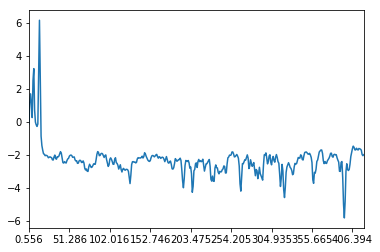

In [23]:
vT.plot()

So we have the temperature differencial here... Or so I think. The only problem now is how to advance this into the thermal conductivity. I believe we have a rough idea. This involves using the following relationship:


$$4\pi\sum^N_{i=1} k_{s,i}m_i l_i = \sum^N_{i=1}q_i = \sum^N_{i=1}\frac{\delta T_i}{R_i} = \frac{\sum^N_{i=1}(T_{an,i}-T_{b,i})}{R_g+R_{conv}+R_{cond}} = Q$$ 

This shoud apply to any given time step.

Now here are some known parameters: 

$k_g = 2.77 W/m\cdot K$

$k_{ep} = 22.5 W/m\cdot K$

$d_{eo} = 0.1651 m = 2r_b$

$Len = 408.43 m$

$R_g = \frac{ln(\frac{d_{eo}+ 0.004)}{d_{eo}})}{2\pi k_g}$ + $\frac{ln(\frac{d_{eo})}{d_{ei}})}{2\pi k_{ep}}$ + $\frac{1}{\pi d_{ei}h_{po}}$

_If necessary: This could also be calculated for any flow rate_

We now mostly just want to convert testv.py to something that we can easily get the hpo and Rg out of using any given deo, dei, Len and flow rates. This should be easy. The next step would therefore be casually converting the strin series with their index values (depths) into what we already know to be correct... 

It's important to stress this again: **$m$ is the gradient of temperature over natural log of time in hours**.

In [25]:
import numpy as np

In [154]:
def mfdf10(df):
    df = df[df['hrs']>10]
#     all3[all3['hrs']>10]
    tar = df.set_index('hrs')
    tcol= tar.columns[:-1]
    dt = pd.DataFrame(columns = tcol)
    for i in tcol:
        dt[i]= np.gradient(tar.iloc[:-1][i],np.log(tar.iloc[:-1].index.values.astype(float)))
    return dt
def mmf(df):
    mdf = mfdf10(df)
    return mdf.mean()

In [164]:
mmf(all3).plot(label='3-In-Pipe',figsize=(12,5))
mmf(all4).plot(label='4-Grout')
plt.legend()
plt.title('m-Value variation with respect to elevations')

Text(0.5,1,'m-Value variation with respect to elevations')

In [194]:
all3.columns

Index([u'0.556', u'1.571', u'2.5860000000000003', u'3.6', u'4.615', u'5.629',
       u'6.644', u'7.659', u'8.673', u'9.687999999999999',
       ...
       u'415.526', u'416.54', u'417.555', u'418.569', u'419.584', u'420.599',
       u'421.61300000000006', u'422.62800000000004', u'hrs', u'Hin'],
      dtype='object', length=419)

Now just write a program that takes mi, li ? vT to generate ks.

In [165]:
vT.plot(figsize=(12,5))

In [175]:
ta3 = all3.transpose()
ta4 = all4.transpose()

In [178]:
ta3[ta3.columns[0]][:-4].plot(label='C3 - annulus',figsize=(16,4))
ta4[ta4.columns[0]][:-4].plot(label='C4 - grout')
plt.legend()

In [179]:
import testv as tv

In [180]:
tv.cbhe().Rg

0.015338707676900707

In [181]:
import testv as tv
def gks(dt,m,li):
    rb = tv.cbhe().Rg #Rg = 0.015 
    return dt/rb/4/np.pi/m/li

In [188]:
DIS0 = all3.columns.values[:-2].astype(float)

In [198]:
np.append(0,np.diff(DIS0))

array([0.   , 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014,
       1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014,
       1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015,
       1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014,
       1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015,
       1.014, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015,
       1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014,
       1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015,
       1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015,
       1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014,
       1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015,
       1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014, 1.015,
       1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015, 1.014,
       1.015, 1.015, 1.014, 1.015, 1.014, 1.015, 1.015, 1.014, 1.015,
       1.014, 1.015,

In [205]:
gks(vT,mmf(all3),np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float)))).describe()

count      415.000000
mean       100.068381
std       1541.265392
min       -315.458936
25%         -6.540274
50%         -3.746489
75%         -2.442388
max      25195.279194
dtype: float64

In [206]:
kss = gks(vT,mmf(all3),np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float))))

In [217]:
kss = kss[kss<15]
kss = kss[kss>-30]

In [224]:
inst = kss.index.values.astype(float)
inst = ['%.3f' % elem for elem in inst]

In [234]:
kss.index = inst

In [235]:
kss.plot(figsize=(12,5))

In [239]:
np.mean(all3.mean() - all4.mean())

-2.1882770473664004

In [241]:
gks(-2.18,3.28,420.8)*420.8

-3.44813304895317

In [220]:
kss.sum()

-1900.916224414187

In [151]:
mmf(al3_10).mean()

2.8156005559148056

In [152]:
mmf(al4_10).mean()

2.8639498280637845

In [85]:
tar = al3_10inhr.transpose()

In [120]:
tar.columns

Float64Index([10.0361111111, 10.1030555556, 10.1697222222, 10.2363888889,
              10.3027777778, 10.3697222222, 10.4363888889, 10.5030555556,
              10.5697222222, 10.6363888889,
              ...
              48.1697222222, 48.2361111111, 48.3508333333, 48.3677777778,
              48.3844444444, 48.4011111111, 48.4177777778, 48.4344444444,
              48.4511111111, 48.4844444444],
             dtype='float64', name=u'hrs', length=532)

In [119]:
tar.index.values[:-1].astype(float)

array([  0.556,   1.571,   2.586,   3.6  ,   4.615,   5.629,   6.644,
         7.659,   8.673,   9.688,  10.702,  11.717,  12.731,  13.746,
        14.761,  15.775,  16.79 ,  17.804,  18.819,  19.834,  20.848,
        21.863,  22.877,  23.892,  24.907,  25.921,  26.936,  27.95 ,
        28.965,  29.98 ,  30.994,  32.009,  33.023,  34.038,  35.053,
        36.067,  37.082,  38.096,  39.111,  40.126,  41.14 ,  42.155,
        43.169,  44.184,  45.199,  46.213,  47.228,  48.242,  49.257,
        50.271,  51.286,  52.301,  53.315,  54.33 ,  55.344,  56.359,
        57.374,  58.388,  59.403,  60.417,  61.432,  62.447,  63.461,
        64.476,  65.49 ,  66.505,  67.52 ,  68.534,  69.549,  70.563,
        71.578,  72.593,  73.607,  74.622,  75.636,  76.651,  77.666,
        78.68 ,  79.695,  80.709,  81.724,  82.739,  83.753,  84.768,
        85.782,  86.797,  87.812,  88.826,  89.841,  90.855,  91.87 ,
        92.884,  93.899,  94.914,  95.928,  96.943,  97.957,  98.972,
        99.987, 101.

In [121]:
tar.head(5)

hrs                 10.036111  10.103056  10.169722  10.236389  10.302778  \
0.556                  27.206     27.145     27.162     27.145     27.160   
1.571                  24.361     24.441     24.368     24.276     24.361   
2.5860000000000003     21.131     21.191     21.047     21.124     21.131   
3.6                    19.846     19.629     19.562     19.678     19.638   
4.615                  18.589     18.684     18.592     18.580     18.484   

hrs                 10.369722  10.436389  10.503056  10.569722  10.636389  \
0.556                  27.252     27.235     27.038     27.244     27.231   
1.571                  24.446     24.363     24.294     24.323     24.288   
2.5860000000000003     21.160     21.027     21.062     21.110     20.960   
3.6                    19.686     19.601     19.561     19.622     19.633   
4.615                  18.570     18.398     18.510     18.634     18.535   

hrs                 ...  48.169722  48.236111  48.350833  48.367778  \
0.556               ...     34.973     34.725     34.973     34.738   
1.571               ...     31.581     31.476     31.253     31.793   
2.5860000000000003  ...     27.735     27.608     27.601     27.429   
3.6                 ...     25.729     25.705     25.803     25.675   
4.615               ...     24.272     24.268     24.159     24.347   

hrs                 48.384444  48.401111  48.417778  48.434444  48.451111  \
0.556                  34.605     34.748     34.766     34.487     34.424   
1.571                  31.235     31.462     31.586     31.400     31.146   
2.5860000000000003     27.412     27.454     27.769     27.705     27.242   
3.6                    25.596     25.510     26.049     25.788     25.832   
4.615                  24.084     24.123     24.395     24.499     24.305   

hrs                 48.484444  
0.556                  34.717  
1.571                  31.315  
2.5860000000000003     27.672  
3.6                    25.646  
4.615                  24.288  

[5 rows x 532 columns]

In [115]:
def mfbh10(df):
    dfinhr = df.set_index('hrs')
    dfT = dfinhr.transpose()
    dft = dfT.drop('Hin')
#     dft['hr'] = dft.index.values.astype(float)
    print np.gradient(dft.mean(),np.log(dft.index.values.astype(float)))
    return dft

In [116]:
mfbh10(al3_10)

ValueError: when 1d, distances must match the length of the corresponding dimension

In [81]:
warrant = mfbh10(al3_10).index.values

In [82]:
np.array(map(float,warrant))

ValueError: could not convert string to float: Hin

In [ ]:
grad1 = np.gradient(al3_10)

In [101]:
df = pd.read_csv(f23[0],header=25,sep='\t')
df.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True

In [115]:
DF = df[df['depth']>0]
DF = DF.set_index('depth')
DF = DF.transpose()

In [118]:
DF.append(DF.loc['tempc'])

depth       0.556     1.571     2.586     3.600     4.615     5.629    \
tempc        35.028    31.922    27.816    25.583    23.846    20.057   
stokes     1511.683  1482.592  1417.013  1330.393  1282.809  1224.095   
nonstokes  1326.245  1279.463  1195.928  1108.970  1058.872   988.736   
tempc        35.028    31.922    27.816    25.583    23.846    20.057   

depth       6.644     7.659     8.673     9.688    ...  413.496  414.511  \
tempc         9.562     1.082    -0.043    -0.307  ...   18.426   18.397   
stokes     1132.814  1086.536  1080.632  1077.299  ...  798.622  798.540   
nonstokes   859.212   780.507   770.431   766.641  ...  616.650  616.426   
tempc         9.562     1.082    -0.043    -0.307  ...   18.426   18.397   

depth      415.526  416.540  417.555  418.569  419.584  420.599   421.613  \
tempc       18.213   18.340   18.194   17.978   18.067   18.243   150.779   
stokes     798.468  797.638  797.397  796.318  795.635  795.057  1355.958   
nonstokes  615.654  615.416  614.651  612.991  612.728  612.861  1779.870   
tempc       18.213   18.340   18.194   17.978   18.067   18.243   150.779   

depth       422.628  
tempc       130.645  
stokes     1437.682  
nonstokes  1779.996  
tempc       130.645  

[4 rows x 417 columns]

In [72]:
f24 = fl[3]
all4 = pd.DataFrame(index=pd.read_csv(f24[1],header=25,sep='\t')['length (m)'].values)

for i in range(len(f24)):
    fram = pd.read_csv(f24[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    all4[str(f24[i])[-25:-25+8]+str(f24[i])[-25+9:-25+15]]=fram.tempc.values

In [74]:
C3 = all3[all3.index.values > 0]
C4 = all4[all4.index.values > 0]

ins = C3.index.to_list()
import pickle
with open('ins','wb') as f:
    pickle.dump(ins,f)

In [85]:
C3.index.values.to_csv('Depthprof.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [83]:
C4.index

Float64Index([  0.556,   1.571,   2.586,     3.6,   4.615,   5.629,   6.644,
                7.659,   8.673,   9.688,
              ...
              413.496, 414.511, 415.526,  416.54, 417.555, 418.569, 419.584,
              420.599, 421.613, 422.628],
             dtype='float64', length=417)

In [78]:
C3.columns[0]

'20190910174210'

In [79]:
C4.columns[0]

'20190910174311'

In [34]:
s1[7:16]

'channel 1'

In [35]:
M = fl[0]

In [38]:
import bisect
M[bisect.bisect_left(M, 'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf')]

'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf'

In [40]:
M[bisect.bisect_right(M, 'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf'):]

['pt0919/channel 1/2019/sep/channel 1 20190910 155611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 161211 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 161611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 163211 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 163611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 165211 00001.ddf',
 'pt0919/c